### Tasks - project 4

Identifying regulatory interactions
Single cell RNA sequencing data allows the measurement of all genes in many cells at the same time. Genes are often co-regulated, or regulate each other. Correlation, anti-correlation or mutual information between pairs of genes can hint regulatory interactions, and help in reconstructing regulatory networks.

*	Background single cell RNA sequencing
*	Data – any single cell RNA-sequencing data.
*	Filter out genes that are not expressed
*	Replace values lower than one by one. log2 transform the data
*	Identify pairs of genes that are significantly correlated (alternatively, anti-correlated or have mutual information). Take into account the problem of multiple comparisons
*	Test if those gene pairs are also correlated in the other dataset. 
*	For at least one correlated pair of genes, see if you can find research about interaction or functional relationships between those genes. 


In [306]:
from sys import getsizeof
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import mutual_info_score
from scipy.stats.stats import pearsonr   




In [263]:
def calc_MI(x, y, bins=12):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

In [264]:
x, y = range(1000), range(1000)

calc_MI(x, y, 12)

2.4848906709938423

In [265]:
np.corrcoef(x,y)

array([[ 1.,  1.],
       [ 1.,  1.]])

In [266]:
% ls data/

GSE81383_data_melanoma_scRNAseq_BT_Mel.txt
GSE82187_cast_all_forGEO.csv
GSE83533_AML_130_Rel_rpkm.txt
unused/


In [267]:
!du -h data/GSE83533_AML_130_Rel_rpkm.txt

9.1M	data/GSE83533_AML_130_Rel_rpkm.txt


In [268]:
path = '/Users/mdymshits/comp_bio/data/GSE83533_AML_130_Rel_rpkm.txt'
df = pd.read_csv(path, delimiter='\t')

In [269]:
df = df.iloc[:, 1:].T
df.columns = df.iloc[0]
df = df.reindex(df.index.drop('gene'))
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [334]:
df.columns = ['_'.join([col, str(i)]) for i, col in enumerate(df.columns)]

In [271]:
df.iloc[:10,:10]

,TAF1L_0,RNU6-69_1,ROCK1_2,SNORD115-42_3,OR8B2_4,LYN_5,SNORD115-43_6,OR8B3_7,OR2AT4_8,KCTD14_9
0,0,0,40.0059,0,0,4.95385,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,70.5803,0,0,2.86212,0,0,0,0
3,0,0,24.1233,0,0,144.22,0,0,0,0
4,0,0,2.9105,0,0,0.665994,0,0,0,0
5,0,0,0.0638631,0,0,0,0,0,0,0
6,0,0,29.135,0,0,0,0,0,0,0
7,0,0,80.7414,0,0,0,0,0,0,0
8,0,0,22.4341,0,0,1.01223,0,0,0,0
9,0,0,11.2208,0,0,6.37025,0,0,0,0


In [272]:
# %%time
for gene in df:
    for ind, val in df[gene].iteritems():
        if val <= 1:
#             df.iloc[j, i] = 0
            df.set_value(index=ind, col=gene, value=0)
        elif val > 1:
#             df.iloc[j, i] = np.log2(val)
            df.set_value(index=ind, col=gene, value=np.log2(val))
        
           

In [273]:
cnt = 0
zeros = []
for col in tqdm(df):
#     if (df[col].values < 1).all():
    if np.sum((df[col].values > 1)) < 40:        
        
#         print i, col, cnt
        cnt += 1
        zeros.append(col)
print cnt
df.drop(zeros, axis=1, inplace=True)



  0%|          | 0/96 [00:00<?, ?it/s]
6051it [00:00, 60504.58it/s]          
12268it [00:00, 60992.94it/s]
18052it [00:00, 60010.80it/s]
23737it [00:00, 59610.28it/s]

22843


In [274]:
df.shape

(96, 894)

In [340]:
%%time
cor = np.corrcoef(df.values.astype(dtype='float').T)

CPU times: user 12.9 ms, sys: 3.24 ms, total: 16.1 ms
Wall time: 11.6 ms


In [341]:
cor.shape

(894, 894)

In [342]:
col_names = df.columns

In [343]:
cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) > .9:
            cor_genes['__'.join([col_names[i], col_names[j]])] = cor[i,j]
#             print cor[i,j], col_names[i], col_names[j]




  0%|          | 0/894 [00:00<?, ?it/s]


 73%|███████▎  | 654/894 [00:00<00:00, 6535.88it/s]


100%|██████████| 894/894 [00:00<00:00, 5201.51it/s]

In [344]:
len(cor_genes)

3

In [345]:
cor_genes

{'MTRNR2L1_22884_865__MTRNR2L2_6347_241': 0.92660197099608821,
 'NACA2_16179_618__NACA_6238_236': 0.93002162024969215,
 'RPL23P8_22973_869__RPL23_1895_67': 0.90667917617854832}

In [84]:
!which python


/Users/mdymshits/virtualenv/tf_new/bin/python


In [236]:
non_cor_genes = {}
for i in tqdm(range(cor.shape[0])):
    for j in range(cor.shape[0]):
        if j >= i:
            continue
        if abs(cor[i,j]) < .01:
            non_cor_genes['__'.join([col_names[i], col_names[j]])] = cor[i,j]


100%|██████████| 5596/5596 [00:09<00:00, 621.16it/s] 


In [226]:
len(non_cor_genes) / 10. ** 6

1.125782

In [228]:
getsizeof(non_cor_genes) / 10. ** 6

50.331928

In [108]:
nbins = 12

In [239]:
mi = []
for i, key in enumerate(non_cor_genes):
    gen1, gen2 = key.split('__')
#     print gen1, gen2
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                             bins=nbins)
    mi.append(val)
#     print gen1, gen2, val
    
    if i > 5000:
        break
# print mi
print np.mean(mi), np.std(mi)   

0.184685052079 0.0962790748284


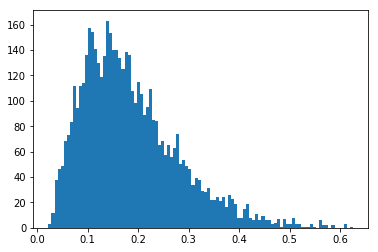

In [240]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(mi, bins= 100);

In [171]:
pearsonr(df['C14orf182_14784'].values, df['SCAMP4_1724'].values)


(0.99999290097138094, 1.1719553056952381e-229)

In [173]:
for i, j in zip(df['C14orf182_14784'].values, df['SCAMP4_1724'].values):
    print i, j

0 0
0 0.0215222755888
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
5.83138113446 5.71168935272
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0
0 0


In [347]:



mi_corr = {}
for i, key in enumerate(cor_genes):
    gen1, gen2 = key.split('__')
    val = calc_MI(df[gen1].values.astype(dtype='float'),
                  df[gen2].values.astype(dtype='float'),
                                            bins=n_bins)
    mi_corr['__'.join([gen1, gen2])] = val
#     print gen1, gen2, val
#     print df[gen1].values
#     print df[gen2].values
#     print df[gen1]
#     if i > 10:
#         break
print np.mean(mi_corr.values()), np.std(mi_corr.values())
print mi_corr
# print mi

2.74784039596 0.119932230853
{'RPL23P8_22973_869__RPL23_1895_67': 2.7437783805629277, 'NACA2_16179_618__NACA_6238_236': 2.603027149359276, 'MTRNR2L1_22884_865__MTRNR2L2_6347_241': 2.896715657947885}


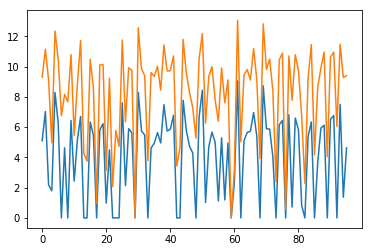

In [350]:
plt.fig
plt.plot(df['RPL23P8_22973_869'])
plt.plot(df['RPL23_1895_67'])

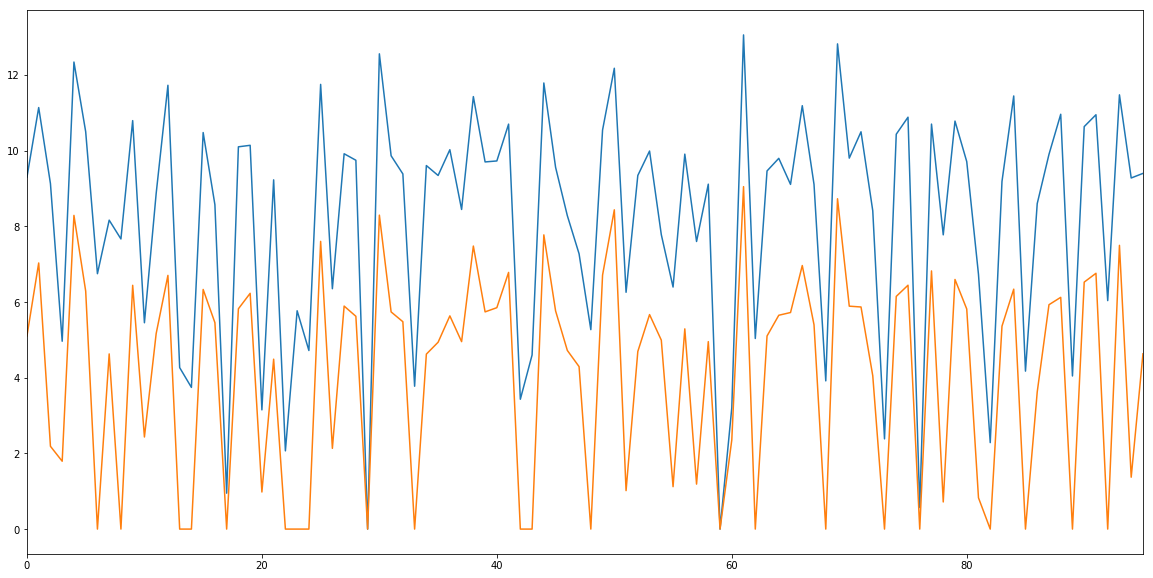

In [355]:
df['RPL23_1895_67'].plot(figsize=(20,10))
df['RPL23P8_22973_869'].plot(figsize=(20,10))


In [310]:
max(mi_corr)


2.896715657947885

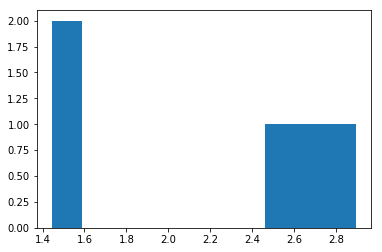

In [243]:
plt.hist(mi_corr, bins= 10);

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
bins = 20
# bins = range(1, 10, 2 ) + range(11,100, 10) + range(101, 1200, 50)
plt.hist(df.iloc[:,5:].T.astype(bool).sum(axis=1), bins=bins);
# plt.xlim(0, 200)

In [ ]:
bins

In [ ]:
calc_MI(range(10000),[0] * 10000, bins=200)

In [ ]:
for i in df['Kcnj8']:
    print i

In [107]:
df.iloc[3,1:].values

array([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 5.2855320079740196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       8.7694828431322058, 0.0, 0.0, 1.7785250384578839, 0.0, 0.0, 0.0,
       0.0, 0.0, 4.0134290497489413, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       3.982344744266253, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 1.2025050898239091, 7.3047016287580639, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 6.3834992981335219, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 3.1228385949012463, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
       0.0, 0.0, 0.0, 0.0, 0.0, 0.0], dtype=object)

In [ ]:
df.shape

In [165]:
n = 100
a = np.zeros(n)
b = np.zeros(n)

In [281]:
df.shape

(96, 894)

In [295]:
mi_genes = {}

for i, gen1 in enumerate(df):
    for j, gen2 in enumerate(df):
        if j >= i:
            continue
        val = calc_MI(df[gen1].values.astype(dtype='float'),
                      df[gen2].values.astype(dtype='float'),
                                               bins=n_bins)
        
        mi_genes['__'.join([gen1, gen2])] = val
    if i % 40 == 0: print i

0
40
80
120
160
200
240
280
320
360
400
440
480
520
560
600
640
680
720
760
800
840
880


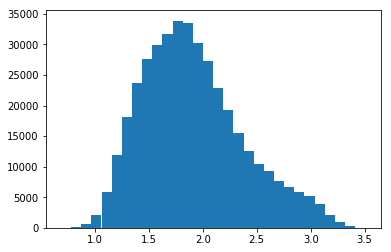

In [297]:
plt.hist(mi_genes.values(), bins=30);

In [321]:
for g in mi_genes:
    if mi_genes[g] > 3.45:
        print g, mi_genes[g]

PRRC2C_15178__GAPDH_6672 3.47312742305
GAPDH_6672__RPS3_4855 3.45041784899
GAPDH_6672__FTH1_5278 3.49019998451
PRRC2C_15178__TXNIP_3057 3.47030891675
FTH1_5278__TXNIP_3057 3.47294091195
PRRC2C_15178__FTH1_5278 3.45514729352
GAPDH_6672__TXNIP_3057 3.50536160774
ANXA1_8062__GAPDH_6672 3.4692857344
NFKBIA_12234__TXNIP_3057 3.45586835049


In [328]:
for g in mi_corr:
    if mi_corr[g] > 2.8:
        print g, mi_corr[g]

TypeError: list indices must be integers, not numpy.float64

In [329]:
mi_corr

[2.896715657947885,
 2.7437783805629277,
 1.4440872332390247,
 1.4646788615513699,
 2.603027149359276]

In [358]:
df['PRRC2C_15178'].values
df['GAPDH_6672'].values

KeyError: 'PRRC2C_15178'

In [357]:
df['PRRC2C_15178'].plot(figsize(10,20))
df['GAPDH_6672'].plot(figsize(10,20))

KeyError: 'PRRC2C_15178'

In [315]:
a = [0,0,0,0,0,1,2]
b = [1,2,0,0,0,0,0]

In [316]:
pearsonr(b,a)

(-0.34615384615384615, 0.44691561945013086)

In [317]:
calc_MI(a,b)

0.1175469692929314

In [159]:
np.var(a)

0.0024749999999999993

In [160]:
np.var(b)


0.0

In [177]:
np.sum(a > 0)


1